## Clone the repository

In [ ]:
!git clone https://github.com/JA-Bar/nlp-depression

Cloning into 'nlp-depression'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls
%cd nlp-depression

drive  nlp-depression  sample_data
/content/nlp-depression


### Getting the dataset from kaggle (skip if it's already in drive)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!pip3 install kaggle

In [ ]:
!ls /content/drive/MyDrive/Carrera/Decimo/nlp/data_processing/

exploration_and_visualization.ipynb


In [ ]:
!kaggle datasets download -d nikhileswarkomati/suicide-watch \
                          -p /content/drive/MyDrive/Carrera/Decimo/nlp/data_processing/

 81% 49.0M/60.6M [00:00<00:00, 36.1MB/s]
100% 60.6M/60.6M [00:00<00:00, 65.5MB/s]


In [ ]:
# remove your kaggle token from colab
!rm ~/.kaggle/kaggle.json

### Unzipping from drive to colab's file system

In [ ]:
# unzip the data
!unzip /content/drive/MyDrive/Carrera/Decimo/nlp/data_processing/suicide-watch.zip \
       -d data/depression/

Archive:  /content/drive/MyDrive/Carrera/Decimo/nlp/data_processing/suicide-watch.zip
  inflating: data/depression/Suicide_Detection.csv  


### Preprocessing

In [ ]:
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pandas as pd
import seaborn as sns


nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data = pd.read_csv('./data/depression/Suicide_Detection.csv')

In [ ]:
pattern_url = re.compile(r'\[(.+)\]\(.+\)')  # markdown links
pattern_subreddit = re.compile(r'r/\w+\b')  # subreddits
pattern_user = re.compile(r'u/\w+\b')  # users

# from: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
pattern_emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

def replace_words(string):
    string = pattern_url.sub('_URL_', string)
    string = pattern_subreddit.sub('_SUB_', string)
    string = pattern_user.sub('_USER_', string)
    string = pattern_emoji.sub('', string)
    return string

In [ ]:
# remove usernames, links, subs, and emojis
data['text'] = data['text'].apply(replace_words)

# remove reddit anomalies
data = data[data['text'].str.find('[removed]') == -1]
data = data[data['text'].str.find('[deleted]') == -1]

In [ ]:
data.head(2)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide


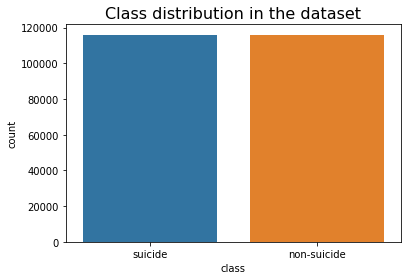

In [ ]:
g = sns.countplot(x='class', data=data)
g.set_title('Class distribution in the dataset', {'fontsize': 16})
g.figure.savefig('class_dist.png')

### Frequency analysis

In [ ]:
data_suicide = data[data['class'] == 'suicide']
data_non_suicide = data[data['class'] == 'non-suicide']

In [ ]:
# suicide data
print('separating into words...')
all_words_suicide = []
data_suicide['text'].apply(lambda s: all_words_suicide.extend([w.lower() for w in word_tokenize(s)]))

print('making frequency dataframe')
frequency_suicide = nltk.FreqDist(all_words_suicide)
unique_words_suicide = set(all_words_suicide)
unique_words_suicide = sorted(unique_words_suicide, key=lambda w: frequency_suicide[w], reverse=True)

frequency_suicide_df = {'word': [], 'frequency': []}
for w in unique_words_suicide:
    frequency_suicide_df['word'].append(w)
    frequency_suicide_df['frequency'].append(frequency_suicide[w])

frequency_suicide_df = pd.DataFrame(frequency_suicide_df)

separating into words...
making frequency dataframe


In [ ]:
# non-suicide data
print('separating into words...')
all_words_non_suicide = []
data_non_suicide['text'].apply(lambda s: all_words_non_suicide.extend([w.lower() for w in word_tokenize(s)]))

print('making frequency dataframe')
frequency_non_suicide = nltk.FreqDist(all_words_non_suicide)
unique_words_non_suicide = set(all_words_non_suicide)
unique_words_non_suicide = sorted(unique_words_non_suicide, key=lambda w: frequency_non_suicide[w], reverse=True)

frequency_non_suicide_df = {'word': [], 'frequency': []}
for w in unique_words_non_suicide:
    frequency_non_suicide_df['word'].append(w)
    frequency_non_suicide_df['frequency'].append(frequency_non_suicide[w])

frequency_non_suicide_df = pd.DataFrame(frequency_non_suicide_df)

separating into words...
making frequency dataframe


In [ ]:
frequency_suicide_df.head()

,word,frequency
0,i,1835443
1,.,1376106
2,to,848796
3,",",825871
4,and,706361


In [ ]:
frequency_suicide_df['frequency'].sum()

27413974

In [ ]:
frequency_non_suicide_df.head()

,word,frequency
0,i,361876
1,.,272016
2,",",211685
3,and,189374
4,to,186749


In [ ]:
frequency_non_suicide_df['frequency'].sum()

8220049

Notes as data is seen:
- Suicide posts appear to be much longer than non-suicide
- Take that into account, maybe crop them?
- Should we remove stopwords or does the quantity of say, pronouns, hold significant information?


In [ ]:
# remove things such as negatives from being considered stopwords
stopwords_filtered = stopwords.words('english')[:stopwords.words('english').index('aren')]

Word frequency in suicide posts

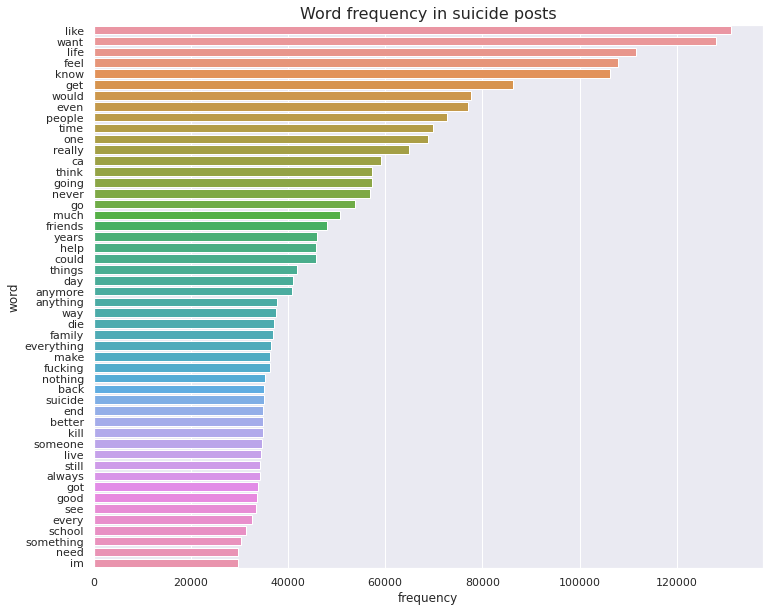

In [ ]:
# remove stopwords and punctuation
filtered_frequency_suicide_df = frequency_suicide_df[~frequency_suicide_df['word'].isin(stopwords_filtered)]
filtered_frequency_suicide_df = filtered_frequency_suicide_df[filtered_frequency_suicide_df['word'].apply(lambda w: w.isalpha())]

sns.set(rc={'figure.figsize':(12, 10)})
g = sns.barplot(x="frequency",
                y="word",
                orient='h',
                data=filtered_frequency_suicide_df.head(50))
g.set_title('Word frequency in suicide posts', {'fontsize': 16})
g.figure.savefig('word_frequency_suic.png')

Word frequency in non-suicide posts

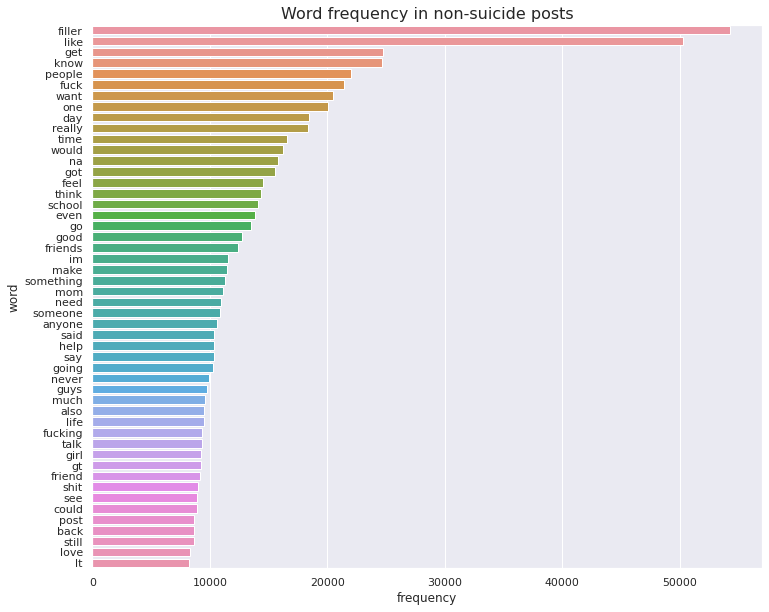

In [ ]:
# remove stopwords and punctuation
filtered_frequency_non_suicide_df = frequency_non_suicide_df[~frequency_non_suicide_df['word'].isin(stopwords_filtered)]
filtered_frequency_non_suicide_df = filtered_frequency_non_suicide_df[filtered_frequency_non_suicide_df['word'].apply(lambda w: w.isalpha())]

sns.set(rc={'figure.figsize':(12, 10)})
g = sns.barplot(x="frequency",
                y="word",
                orient='h',
                data=filtered_frequency_non_suicide_df.head(50))
g.set_title('Word frequency in non-suicide posts', {'fontsize': 16})
g.figure.savefig('word_frequency_non_suic.png')

In [ ]:
del filtered_frequency_non_suicide_df
del filtered_frequency_suicide_df
del frequency_non_suicide
del frequency_suicide
del frequency_non_suicide_df
del frequency_suicide_df
del data_non_suicide
del data_suicide

## Dimensionality reduction and label correction

Embedding sentences using Google's Universal Sentence  (GUSE)



In [ ]:
import tensorflow_hub as hub

from tqdm import tqdm

In [ ]:
guse = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
embedded_data = {'text': [], 'embedding': [], 'class': []}

for i, row in tqdm(data.iterrows(), desc='Embedding posts', total=len(data)):
    embedded_data['text'].append(row['text'])
    embedded_data['embedding'].append(guse([row['text']]))
    embedded_data['class'].append(row['class'])i

Embedding posts: 232040it [22:10, 174.43it/s]


In [ ]:
embedded_data = pd.DataFrame(embedded_data)

In [ ]:
embedded_data.to_pickle('data/depression/Suicide_Detection_Embedded.pkl', protocol=4)

In [ ]:
# backup the file to drive so it doesn't get lost if the runtime dies
!cp data/depression/Suicide_Detection_Embedded.pkl /content/drive/MyDrive/Carrera/Decimo/nlp/data_processing/Suicide_Detection_Embedded.pkl

Reducing the dimensionality of data with UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, so clustering algorithms are more effective.

In [ ]:
!pip3 install umap-learn

     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 1.2MB 38.6MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=bf64ffc3f440b53af987fb5d79727dd14ab9f771571b5785f94ccb82792c7118
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51362 sha256=1becb5fecb0a0a6608479bccc6483bdafaca869607c02898855a9d14be1f8f27
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
import pickle
import numpy as np
import numpy.matlib
import umap

from sklearn.cluster import KMeans

In [ ]:
reducer = umap.UMAP(
    n_neighbors=45,
    min_dist=0.7,
    n_components=2,
    metric='manhattan'
)

In [ ]:
embeddings_array = np.stack(embedded_data['embedding'].apply(lambda x: x.numpy().reshape(-1)).values)
reduced_embeddings = reducer.fit_transform(embeddings_array)
del embeddings_array

In [ ]:
with open('/content/drive/MyDrive/Carrera/Decimo/nlp/data_processing/reduced_embedding.pkl', 'wb') as f:
    pickle.dump(reduced_embeddings, f)

Then use K-means clustering to find where the vectors cluster in a low dimensional space.

In [ ]:
def soft_clustering_weights(data, cluster_centres, **kwargs):
    
    """
    From: https://towardsdatascience.com/confidence-in-k-means-d7d3a13ca856
    Function to calculate the weights from soft k-means
    data: Array of data. shape = N x F, for N data points and F Features
    cluster_centres: Array of cluster centres. shape = Nc x F, for Nc number of clusters. Input kmeans.cluster_centres_ directly.
    param: m - keyword argument, fuzziness of the clustering. Default 2
    """
    
    # Fuzziness parameter m>=1. Where m=1 => hard segmentation
    m = 2
    if 'm' in kwargs:
        m = kwargs['m']
    
    Nclusters = cluster_centres.shape[0]
    Ndp = data.shape[0]
    Nfeatures = data.shape[1]

    # Get distances from the cluster centres for each data point and each cluster
    EuclidDist = np.zeros((Ndp, Nclusters))
    for i in range(Nclusters):
        EuclidDist[:,i] = np.sum((data-np.matlib.repmat(cluster_centres[i], Ndp, 1))**2,axis=1)
    
    # Denominator of the weight from wikipedia:
    invWeight = EuclidDist**(2/(m-1))*np.matlib.repmat(np.sum((1./EuclidDist)**(2/(m-1)),axis=1).reshape(-1,1),1,Nclusters)
    Weight = 1./invWeight
    
    return Weight

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=100).fit(reduced_embeddings)
predictions = kmeans.predict(reduced_embeddings)

In [ ]:
predictions

array([0, 1, 1, ..., 1, 0, 1], dtype=int32)

If the datapoint is clustered with a confidence of >= 0.9, then its label will be changed to that of the cluster label. It will be untouched otherwise.

- suicide - class 0 in kmeans
- non-suicide - class 1 in kmeans

In [ ]:
soft_kmeans = soft_clustering_weights(reduced_embeddings, kmeans.cluster_centers_)

In [ ]:
corrected_class = []
thresh = 0.9

for i, (_, row) in enumerate(data.iterrows()):
    original_label = 0 if row['class'] == 'suicide' else 1
    corrected_label = np.argmax(soft_kmeans[i], axis=-1)
    if soft_kmeans[i, corrected_label] > thresh:
        final_label = corrected_label
    else:
        final_label = original_label
    
    corrected_class.append(final_label)

In [ ]:
data['corrected_class'] = corrected_class

In [ ]:
(data['class'].apply(lambda c: 0 if c == 'suicide' else 1).values == predictions).sum() / len(data)

0.8844854335459403

88.44% of corrected labels agree with the original dataset, while the remaining 11.56% were changed, this agrees with the literature of estimation of noisy labels.

In [ ]:
data.head()

,Unnamed: 0,text,class,corrected_class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,0
1,3,Am I weird I don't get affected by compliments...,non-suicide,1
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,1
3,8,i need helpjust help me im crying so hard,suicide,0
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,0


In [ ]:
final_data = data.drop(['Unnamed: 0', 'class'], axis=1).rename(columns={'corrected_class': 'sentiment'})

In [ ]:
final_data.to_csv('/content/drive/MyDrive/Carrera/Decimo/nlp/data_processing/corrected_labels_data.csv')

In [ ]:
with open('/content/drive/MyDrive/Carrera/Decimo/nlp/data_processing/corrected_labels_data.pkl', 'wb') as f:
    pickle.dump(final_data, f)